<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/tf-dense-insurance-reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# will also work, but nightly build might contain surprises

# !pip install -q tf-nightly-gpu-2.0-preview

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras

In [0]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/data/insurance-customers-1500.csv', sep=';')

In [0]:
y = df['group'].values
X = df.drop('group', axis='columns').values

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### An experimental approach:
- keep adding regularization to make validation and train scores come closer to each other
- this will come at the cost of train scores going down
- if both values start going down you have gone too far
- each experiment takes some time
- for larger datasets and more complex models some people start by overfitting on a subsample of the data (because it trains much faster)
  - then you can be sure you have an architecture that at least has the capacity to solve the problem
  - then keep adding regularizations
  - eventually try using the complete data
- if you want to use batch normalization place it between raw output of neuron and activation function    

In [7]:
from tensorflow.keras.layers import Input, Dense, Dropout, \
                                    BatchNormalization, Activation

num_features = 3
num_categories = 3

dropout = 0.6
model = keras.Sequential()

model.add(Input(name='input', shape=(num_features,)))

# reduce capacity by decreasing number of neurons
model.add(Dense(500, name='hidden1'))
model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(500, name='hidden2'))
model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(name='output', units=num_categories, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               2000      
_________________________________________________________________
activation (Activation)      (None, 500)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
output (Dense)               (None, 3)                 1503      
Total params: 254,003
Trainable params: 254,003
Non-trainable params: 0
_________________________________________________________________


In [8]:
%%time

# reducing batch size might increase overfitting, 
# but might be necessary to reduce memory requirements 
BATCH_SIZE=1000

# reduce this based on what you see in the training history
EPOCHS = 10000

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)

W0820 10:20:09.139910 139819518117760 deprecation.py:323] From /tensorflow-2.0.0b1/python3.6/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


CPU times: user 1min 16s, sys: 8.7 s, total: 1min 24s
Wall time: 1min 10s


In [9]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

1200/1200 [==============================] - 0s 38us/sample - loss: 0.4068 - accuracy: 0.8858


(0.40680920084317523, 0.8858333)

In [10]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

300/300 [==============================] - 0s 77us/sample - loss: 1.1049 - accuracy: 0.7200


(1.104885458946228, 0.72)

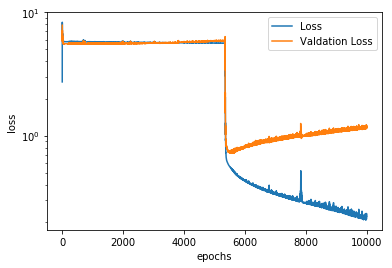

In [11]:
plt.yscale('log')

plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(["Loss", "Valdation Loss"])

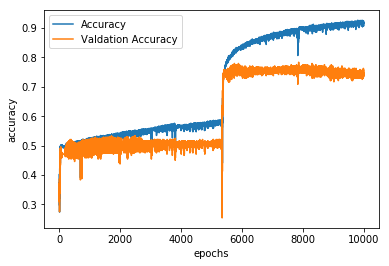

In [12]:
plt.ylabel("accuracy")
plt.xlabel("epochs")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(["Accuracy", "Valdation Accuracy"])

In [13]:
# category 1 should have the highest probability
model.predict(np.array([[100, 48, 10]]))

array([[5.9119247e-05, 9.1252381e-01, 8.7417088e-02]], dtype=float32)

In [0]:
assert model.predict(np.array([[100, 48, 10]])).argmax() == 1